# Jane Stree 2020 EDA



In [1]:
import os, sys
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dtable
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use('dark_background') #plt.style.use('default')

pd.set_option('display.max_columns', 200)

## 0. Load data

In [2]:
ddir='~/learn/kaggle/Data/JaneStreet20' # local
#ddir='../input/jane-street-market-prediction' # kaggle

# using datatable for faster loading
data = dtable.fread(os.path.join(ddir,"train.csv")).to_pandas()
features = pd.read_csv(os.path.join(ddir,"features.csv"))

gc.collect();

0

## 1. Time characterization

Columns 'date' and 'ts_id' indicate dates and time sequence.
 - Number of signals are unevenly distributed over days.
 - Signals may be generated at per second or sub-second scale, based on max count per day


Max #/day= 18884 ,  #/sec 0.21856481481481482
Median #/day= 4353.5 ,  #/sec 0.050387731481481485


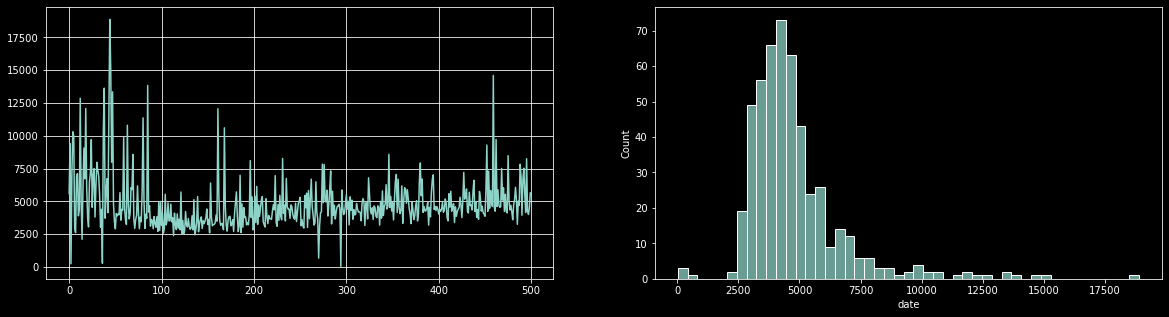

In [5]:
# nnumber opportunities per day
nOpPD=data['date'].value_counts(sort=False)  # nnumber opportunities per day
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
nOpPD.plot(ax=ax[0],grid=True);
sns.histplot(nOpPD,ax=ax[1]);

print('Max #/day=',nOpPD.max(),',  #/sec',nOpPD.max()/(24*3600))
print('Median #/day=',nOpPD.median(),',  #/sec',nOpPD.median()/(24*3600))

## 2. Response

The score probably corresponds to PnL, and is computed in 3 steps. First,
$$ p_k = \sum_j (weight_{kj} \cdot resp_{kj} \cdot action_{kj}), $$
where $k$ index days and $j$ index ts_id. Next, with $n=|k|$ indicating the day counts
$$
t=\frac{\sum_k p_k}{\sqrt{\sum_k p^2_k}} \cdot \sqrt\frac{250}{n} 
= \sqrt{250} \frac{\frac{1}{n} \sum_k p_k}{\sqrt{\frac{\sum_k p^2_k}{n}, }}
$$
which looks like annualized Sharpe Ratio if $p_k$ is interpreted as daily returns. Finally, the utility (score) is given by
$$ u=\min (\max(t,0), 6) \sum+k p_k. $$


The interpretation of the responses and utility is
 - $resp_{kj}$ should be PnL (return) for trade $(k,j)$
 - $weight_{kj}$ should be size of trade $(k,j)$, which is already determined somehow
 - $action_{kj} \in \{0,1\}$ is the decision to be made: to trade or not to trade
 - Score is the product of SR and PnL



### 2.1. Weights

Weights are non-negative, and have a long right tail. In addition, tt has a big impact on $p_k$, hence the final score. It follows that
 - $\to$ per sample weight should be always used in training.

In [22]:
nzWeight=data.loc[data['weight']!=0,'weight']
print('# zero weights:',(data['weight']==0).sum(), ',  #non-zero weights: ',(data['weight']!=0).sum(),
      ',  #NaN in weights:',data['weight'].isna().sum())
print('All weights:')
print(data['weight'].describe() )
print('Non-zero weights')
print(nzWeight.describe() )

# zero weights: 409204 ,  #non-zero weights:  1981287 ,  #NaN in weights: 0
All weights:
count    2.390491e+06
mean     3.031535e+00
std      7.672794e+00
min      0.000000e+00
25%      1.617400e-01
50%      7.086770e-01
75%      2.471791e+00
max      1.672937e+02
Name: weight, dtype: float64
Non-zero weights
count    1.981287e+06
mean     3.657652e+00
std      8.291001e+00
min      6.912442e-03
25%      3.786683e-01
50%      1.072844e+00
75%      3.196557e+00
max      1.672937e+02
Name: weight, dtype: float64


In [23]:
pd.concat(nzWeight.describe(),


pandas.core.series.Series

/home/AWC/wang/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/AWC/wang/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='weight'>

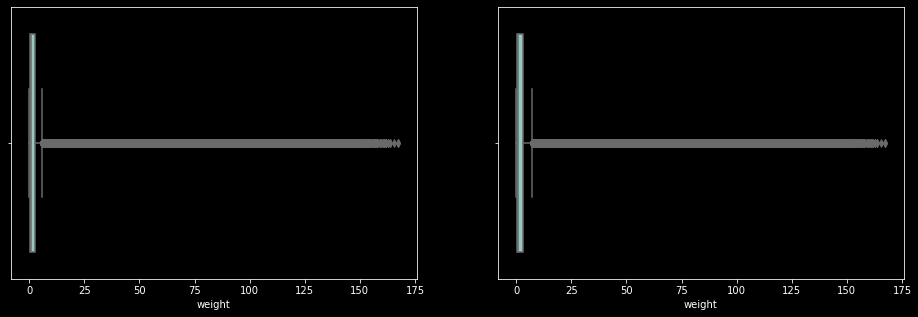

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data['weight'],ax=ax[0]);
sns.boxplot(nzWeight,ax=ax[1]);

In [17]:
data[['weight']].shape

(2390491, 1)